## Implementation of VAE for protein generation from limited sampling MSA

### General Function and Supporting Parts

In [235]:
import time
import numpy as np
import VAE_Tools as tl
from Bio import SeqIO
import sys
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import importlib

importlib.reload(tl)


<module 'VAE_Tools' from '/Users/yaakov/Dropbox/UChicago/Inference_Modules/VAE_Gen/VAE_Tools.py'>

In [146]:
from keras.models import load_model, Model
from keras.layers import BatchNormalization,Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Concatenate, Softmax
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers, losses

In [292]:
MSA_ohr,MSA=tl.load_fasta("CM.fasta");

#h,J=tl.read_bm('CM_10-2.txt');
h,J=tl.read_mat_model('CM_10-2.mat');

In [187]:
energy=tl.DCA_energy(MSA,h,J)

### Here we implement the Variational Version - VAE

In [287]:
## ***** Variationl Autoencoder

L=MSA_ohr.shape[1];
q=21;
inter_dim=1000;inter_dim2=300;
latent=3;
lam0=1;
    # This is the encoding part - into means and sigmas fo distribution
X_input = Input(shape=(L,))
intermediate=Dense(inter_dim,activation='relu')(X_input)
intermediate =Dropout(.2)(intermediate)

z_mean=Dense(latent)(intermediate);
z_log_sigma=Dense(latent)(intermediate);

    # distribution layer
def distribution(args):
    z_mean,z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent),mean=0,stddev=0.1)
    return z_mean+K.exp(z_log_sigma)*epsilon

z = Lambda(distribution)([z_mean, z_log_sigma])
#z = Dropout(.2)(z)
    # encoder
encoder=Model(X_input,[z_mean,z_log_sigma,z])
    
    # decoder
z_input=Input(shape=(latent,))
X=Dense(inter_dim,activation='relu')(z_input)
out=Dense(L,activation='sigmoid')(X)
decoder=Model(z_input,out)

    # variational autoencoder
output=decoder(encoder(X_input)[2])
VAE=Model(X_input,output)
loss=L * losses.binary_crossentropy(X_input,output)
KL_loss=-lam0*0.5 * K.sum(1+z_log_sigma-K.square(z_mean)-K.exp(z_log_sigma),axis=-1)
total_loss=6*K.mean(loss+KL_loss);
VAE.add_loss(total_loss)
VAE.compile(optimizer='adam',metrics=['accuracy'])

In [295]:
ep=100;
fitting=VAE.fit(MSA_ohr,MSA_ohr,epochs=ep,validation_split=0.1,batch_size=50)

Epoch 1/100
23/23 [==============================] - 1s 34ms/step - loss: 1064.7972 - accuracy: 0.0000e+00 - val_loss: 1080.4137 - val_accuracy: 0.0000e+00
Epoch 2/100
23/23 [==============================] - 1s 37ms/step - loss: 1060.0911 - accuracy: 0.0000e+00 - val_loss: 1085.4865 - val_accuracy: 0.0000e+00
Epoch 3/100
23/23 [==============================] - 1s 42ms/step - loss: 1059.8064 - accuracy: 0.0000e+00 - val_loss: 1092.3979 - val_accuracy: 0.0000e+00
Epoch 4/100
23/23 [==============================] - 1s 44ms/step - loss: 1058.9602 - accuracy: 0.0000e+00 - val_loss: 1095.4254 - val_accuracy: 0.0000e+00
Epoch 5/100
23/23 [==============================] - 1s 41ms/step - loss: 1053.5773 - accuracy: 0.0000e+00 - val_loss: 1094.5717 - val_accuracy: 0.0000e+00
Epoch 6/100
23/23 [==============================] - 1s 39ms/step - loss: 1052.6721 - accuracy: 0.0000e+00 - val_loss: 1097.8335 - val_accuracy: 0.0000e+00
Epoch 7/100
23/23 [==============================] - 1s 39ms/ste

23/23 [==============================] - 1s 37ms/step - loss: 1001.1844 - accuracy: 0.0000e+00 - val_loss: 1114.9795 - val_accuracy: 0.0000e+00
Epoch 54/100
23/23 [==============================] - 1s 38ms/step - loss: 1000.9940 - accuracy: 0.0000e+00 - val_loss: 1115.5323 - val_accuracy: 0.0000e+00
Epoch 55/100
23/23 [==============================] - 1s 38ms/step - loss: 998.8031 - accuracy: 0.0000e+00 - val_loss: 1113.2124 - val_accuracy: 0.0000e+00
Epoch 56/100
23/23 [==============================] - 1s 38ms/step - loss: 999.2277 - accuracy: 0.0000e+00 - val_loss: 1117.9922 - val_accuracy: 0.0000e+00
Epoch 57/100
23/23 [==============================] - 1s 38ms/step - loss: 996.1465 - accuracy: 0.0000e+00 - val_loss: 1114.0892 - val_accuracy: 0.0000e+00
Epoch 58/100
23/23 [==============================] - 1s 40ms/step - loss: 993.2892 - accuracy: 0.0000e+00 - val_loss: 1113.8418 - val_accuracy: 0.0000e+00
Epoch 59/100
23/23 [==============================] - 1s 38ms/step - loss: 

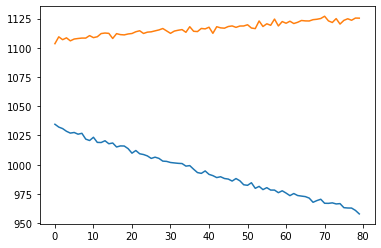

In [296]:
plt.plot(fitting.history['loss'][20:])
plt.plot(fitting.history['val_loss'][20:])

100


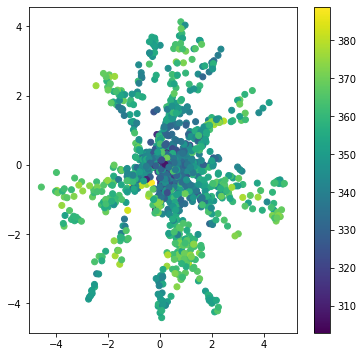

KeyboardInterrupt: 

In [254]:
print(ep)
N=5000
z_vals=np.array(encoder.predict(MSA_ohr))
#plt.figure(figsize=(9, 9))
fig, axs = plt.subplots(1,figsize=(6,6))
cp=axs.scatter(z_vals[2,:,0], z_vals[2,:, 1],c=energy)
plt.colorbar(cp)

#axs[1].scatter(z_vals[2,:,1], z_vals[2,:, 2])
#axs[2].scatter(z_vals[2,:,0], z_vals[2,:, 2])
#plt.colorbar()
plt.show()
rand_z=np.zeros((N,latent))
rand_z[:,1:2]=(np.random.rand(N,1)*5-4)
rand_z[:,0:1]=(np.random.rand(N,1)*8-4)

syn=(decoder.predict(rand_z))
syn_hm=np.array([tl.hardmax(a,q) for a in syn])
syn_num=np.array([tl.reverse_one_hot(a,q) for a in syn_hm]).astype(int)
energy_syn=tl.DCA_energy(syn_num,h,J)
div,divv=tl.diveregnce_from(syn_num,MSA)

fig, axs = plt.subplots(1,2,figsize=(14,6))
cp1=axs[0].scatter(rand_z[:,0], rand_z[:, 1],c=energy_syn)
plt.colorbar(cp1,label='DCA energy')
cp2=axs[1].scatter(rand_z[:,0], rand_z[:, 1],c=divv)
plt.colorbar(cp2,label='Proximity to closest natural')
fig, axs = plt.subplots(1,3,figsize=(19,6))
cp1=axs[0].scatter(rand_z[:,0], rand_z[:, 1],c=divv*(energy_syn>340))
plt.colorbar(cp1,label='DCA energy')
cp11=axs[1].scatter(rand_z[:,0], rand_z[:, 1],c=(energy_syn>340)*(divv>0.3))
plt.colorbar(cp11,label='DCA energy')
cp2=axs[2].scatter(rand_z[:,0], rand_z[:, 1],c=divv)
plt.colorbar(cp2,label='Proximity to closest natural')
filter_MSA=syn_num[(energy_syn>340)*(divv>0.3)]

print(filter_MSA.shape)
print('internal variability ', tl.variability(filter_MSA))
div,divv=tl.diveregnce_from(filter_MSA,MSA)
print('divergence from MSA ',div);

100


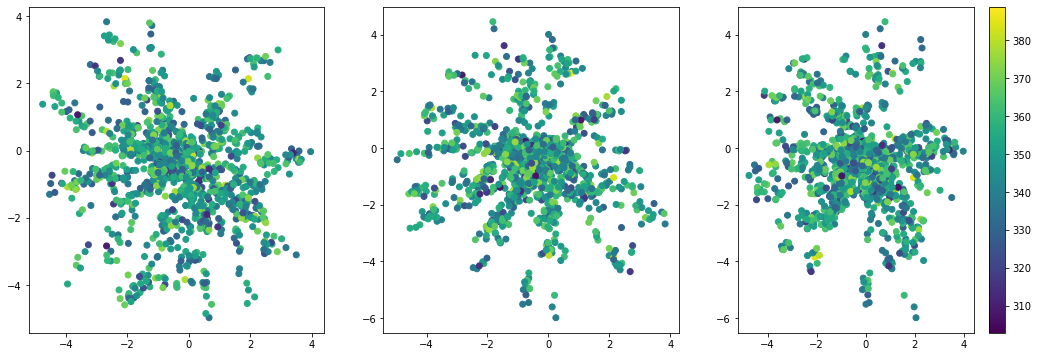

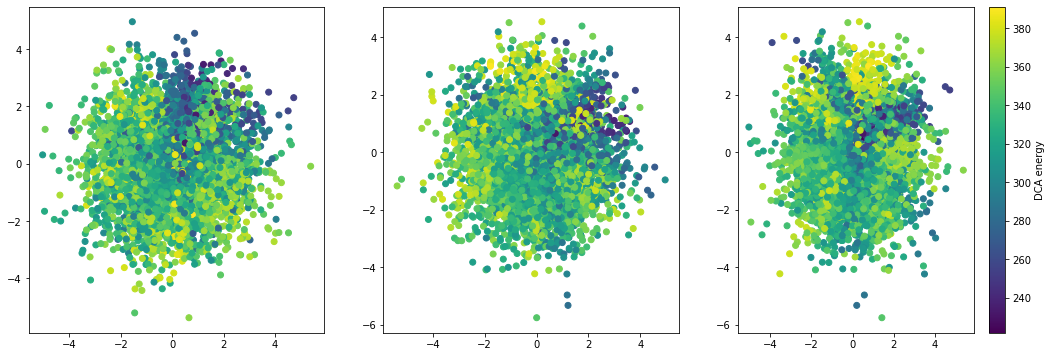

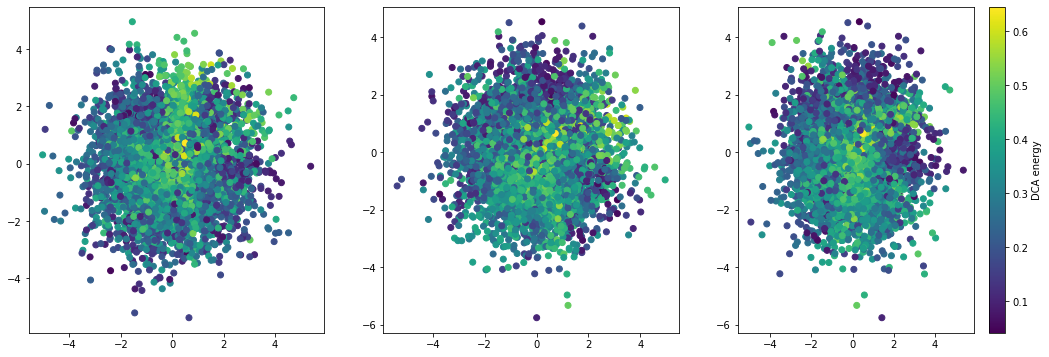

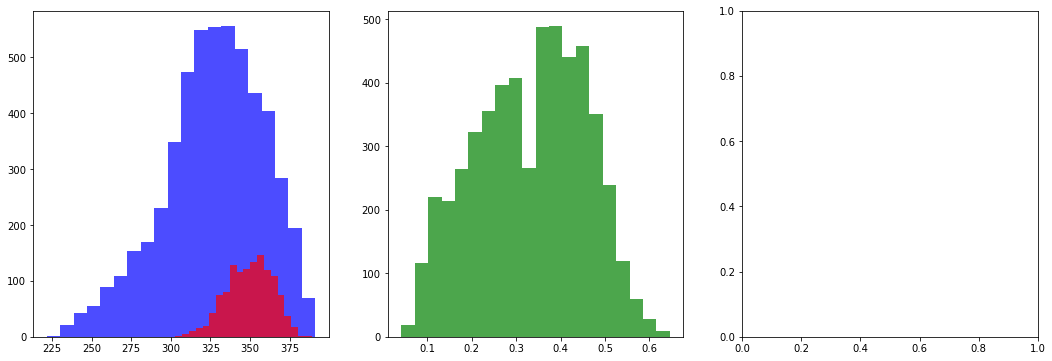

In [297]:
print(ep)
z_vals=np.array(encoder.predict(MSA_ohr))
#plt.figure(figsize=(9, 9))
fig, axs = plt.subplots(1,3,figsize=(18,6))
cp=axs[0].scatter(z_vals[2,:,0], z_vals[2,:, 1],c=energy)
plt.colorbar(cp)
cp=axs[1].scatter(z_vals[2,:,1], z_vals[2,:, 2],c=energy)
cp=axs[2].scatter(z_vals[2,:,0], z_vals[2,:, 2],c=energy)
plt.show()

rand_z=np.random.normal(0,1.4,(5258,latent))
syn=(decoder.predict(rand_z))
syn_hm=np.array([tl.hardmax(a,q) for a in syn])
syn_num=np.array([tl.reverse_one_hot(a,q) for a in syn_hm]).astype(int)
energy_syn=tl.DCA_energy(syn_num,h,J)
div,divv=tl.diveregnce_from(syn_num,MSA)

fig, axs = plt.subplots(1,3,figsize=(18,6))
cp1=axs[0].scatter(rand_z[:,0], rand_z[:, 1],c=(energy_syn))
cp1=axs[1].scatter(rand_z[:,1], rand_z[:, 2],c=(energy_syn))
cp1=axs[2].scatter(rand_z[:,0], rand_z[:, 2],c=(energy_syn))
plt.colorbar(cp1,label='DCA energy')

fig, axs = plt.subplots(1,3,figsize=(18,6))
cp1=axs[0].scatter(rand_z[:,0], rand_z[:, 1],c=divv)
cp1=axs[1].scatter(rand_z[:,1], rand_z[:, 2],c=divv)
cp1=axs[2].scatter(rand_z[:,0], rand_z[:, 2],c=divv)
plt.colorbar(cp1,label='DCA energy')
filter_MSA=syn_num[(energy_syn>320)*(divv>0.3)]

fig, axs = plt.subplots(1,3,figsize=(18,6))

energy_filter=tl.DCA_energy(filter_MSA,h,J)
axs[0].hist(x=energy_syn, bins=20, color='blue',alpha=0.7); 
axs[0].hist(energy, bins=20, color='red',alpha=0.7); 
div,divv=tl.diveregnce_from(syn_num,MSA)
axs[1].hist(x=divv, bins=20, color='green', alpha=0.7) ;


(1499, 96)
internal variability  0.6649089398124192
(to compare, natural:)  0.7786260086072317
divergence from MSA  0.3623457304869913


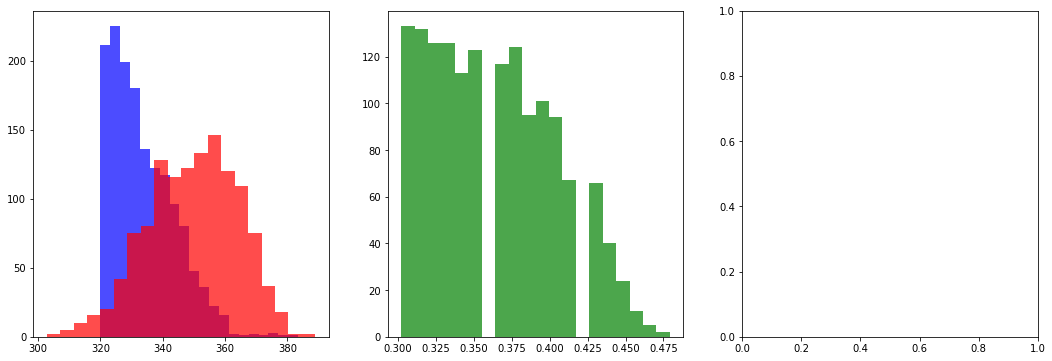

In [294]:
print(filter_MSA.shape)
print('internal variability ', tl.variability(filter_MSA))
print('(to compare, natural:) ', tl.variability(MSA))
div,divv=tl.diveregnce_from(filter_MSA,MSA)
print('divergence from MSA ',div);
fig, axs = plt.subplots(1,3,figsize=(18,6))

energy_filter=tl.DCA_energy(filter_MSA,h,J)
axs[0].hist(x=energy_filter, bins=20, color='blue',alpha=0.7); 
axs[0].hist(energy, bins=20, color='red',alpha=0.7); 
div,divv=tl.diveregnce_from(filter_MSA,MSA)
axs[1].hist(x=divv, bins=20, color='green', alpha=0.7) ;

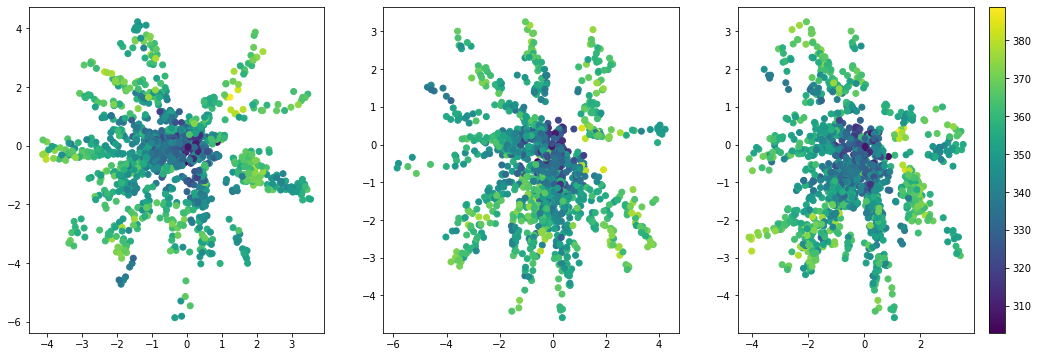

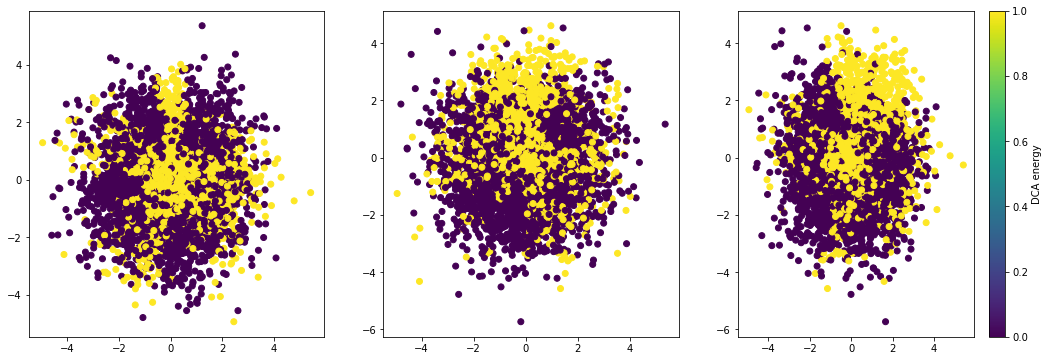

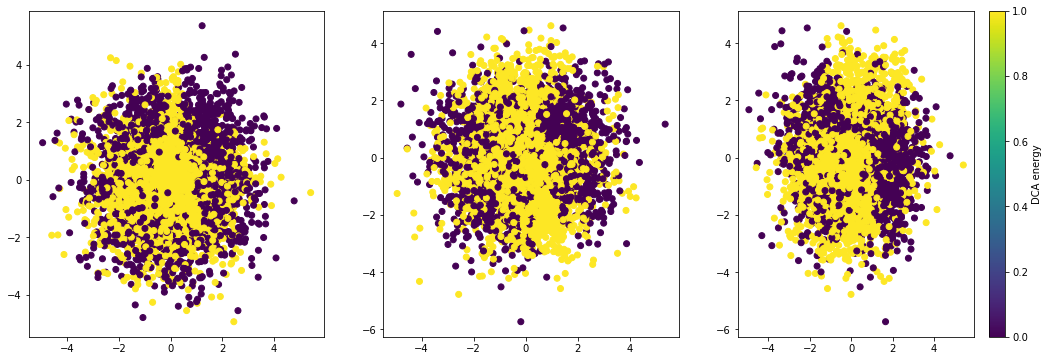

In [285]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
cp=axs[0].scatter(z_vals[2,:,0], z_vals[2,:, 1],c=energy)
plt.colorbar(cp)
cp=axs[1].scatter(z_vals[2,:,1], z_vals[2,:, 2],c=energy)
cp=axs[2].scatter(z_vals[2,:,0], z_vals[2,:, 2],c=energy)
plt.show()

fig, axs = plt.subplots(1,3,figsize=(18,6))
cp1=axs[0].scatter(rand_z[:,0], rand_z[:, 1],c=(energy_syn<320))
cp1=axs[1].scatter(rand_z[:,1], rand_z[:, 2],c=(energy_syn<320))
cp1=axs[2].scatter(rand_z[:,0], rand_z[:, 2],c=(energy_syn<320))
plt.colorbar(cp1,label='DCA energy')
fig, axs = plt.subplots(1,3,figsize=(18,6))
cp1=axs[0].scatter(rand_z[:,0], rand_z[:, 1],c=(divv>0.3))
cp1=axs[1].scatter(rand_z[:,1], rand_z[:, 2],c=(divv>0.3))
cp1=axs[2].scatter(rand_z[:,0], rand_z[:, 2],c=(divv>0.3))
plt.colorbar(cp1,label='DCA energy')